In [25]:
import pandas as pd
import numpy as np
import gc
import matplotlib.pyplot as plt


import seaborn as sns
sns.set(style="whitegrid", color_codes=True)
from statsmodels.tsa.stattools import acf, pacf

from math import sqrt
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_squared_log_error as msle
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import r2_score as r2

import lightgbm as lgb
from lightgbm import early_stopping

In [10]:
# Read csv file
data = pd.read_csv('../input/beijing-air-quality-preprocessed/airquality_data.csv')

In [11]:
# Shape of data
data.shape

(401626, 18)

In [12]:
data.head()

,No,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station
0,1,2013,3,1,0,6.0,18.0,5.0,9.80000,800.0,88.0,0.1,1021.1,-18.6,0.0,7,4.4,5
1,2,2013,3,1,1,6.0,15.0,5.0,11.00000,800.0,88.0,-0.3,1021.5,-19.0,0.0,7,4.0,5
2,3,2013,3,1,2,5.0,18.0,5.2,10.09936,700.0,52.0,-0.7,1021.5,-19.8,0.0,14,4.6,5
3,4,2013,3,1,3,6.0,20.0,6.0,13.60000,320.0,49.8,-1.0,1022.7,-21.2,0.0,13,2.8,5
4,5,2013,3,1,4,5.0,17.0,5.0,15.60000,600.0,73.0,-1.3,1023.0,-21.4,0.0,14,3.6,5


# Train test split

In [13]:
# Split data into train and test
train_data, test = train_test_split(data,
                                    test_size=0.1,
                                    shuffle=False)

In [14]:
# Split data into train and valid
train, valid = train_test_split(train_data,
                                test_size=0.1,
                                shuffle=False)

In [15]:
train.columns

Index(['No', 'year', 'month', 'day', 'hour', 'PM2.5', 'PM10', 'SO2', 'NO2',
       'CO', 'O3', 'TEMP', 'PRES', 'DEWP', 'RAIN', 'wd', 'WSPM', 'station'],
      dtype='object')

# Feature Engineering

# PACF
This function was introduced as part of the Box–Jenkins approach to time series modelling, whereby plotting the partial autocorrelative functions one could determine the appropriate lags **p** in an AR **(p)** model or in an extended ARIMA **(p,d,q)** model.

We choose for example the explanatory variable `PM10` and how it is correlated in time.

We noticed that all variable verify the same plot meaning the best lag is two.

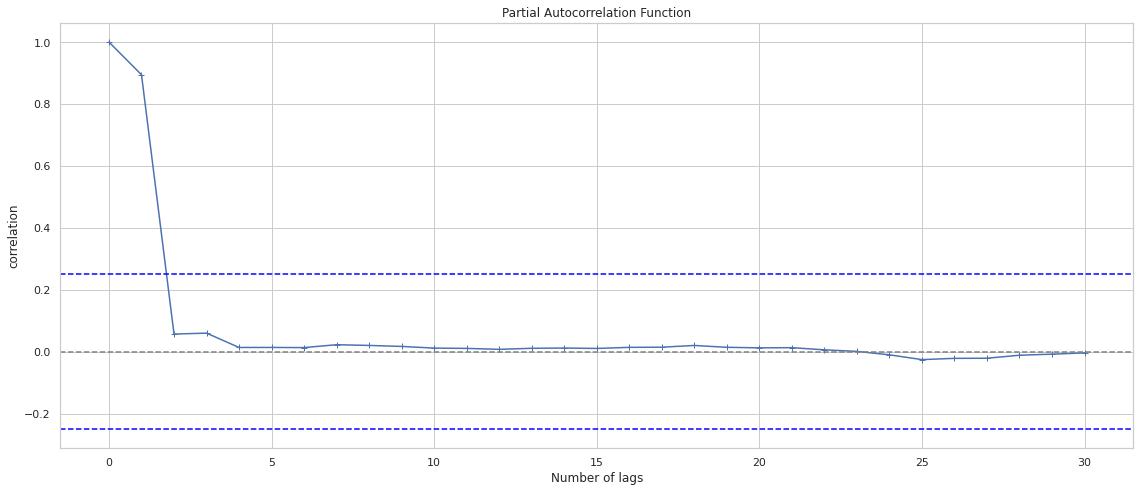

In [28]:
# The variable we choose to apply pacf
y = train['PM10']

#calling partial correlation function
lag_pacf = pacf(y, nlags=30, method='ols')
#Plot PACF:
plt.figure(figsize=(16, 7))
plt.plot(lag_pacf,marker='+')
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y= -((np.std(y) * 1.96)) / np.sqrt(len(y)), linestyle='--',color='blue') # lower bound
plt.axhline(y= ((np.std(y) * 1.96)) / np.sqrt(len(y)),linestyle='--',color='blue') # Upper bound
plt.title('Partial Autocorrelation Function')
plt.xlabel('Number of lags')
plt.ylabel('correlation')
plt.tight_layout()

In [29]:
def series_to_supervised(data_df, lag=2):
    
    '''Create lagged features'''
    
    # We create the lag features with the pandas function shift
    lag_df = data_df[[col for col in data_df.columns if col not in ['No', 'year', 'month', 'day', 'hour']]].shift(lag)
    
    # We rename the columùns by adding lag_{lag_value} at the end
    lag_df.columns = [col+"_"+f"lag_{lag}" for col in lag_df.columns]
    
    return lag_df

def rolling_window(data_df, window=1):
    
    # We create the rolling mean features (MA) with the pandas function shift
    rolling_df = data_df[[col for col in data_df.columns if col not in ['No','station', 'wd', 'year', 'month', 'day', 'hour', 'PM2.5']]].rolling(window).mean()
    
    # We rename the columùns by adding rolling_{window} at the end
    rolling_df.columns = [col+"_"+f"rolling_{window}" for col in rolling_df.columns]
    
    return rolling_df

In [30]:
# Lag features by shift(1) and shift(2)
train_lag1 = series_to_supervised(train, lag=1)
train_lag2 = series_to_supervised(train, lag=2)

# Rolling window by 2
train_rolling2 = rolling_window(train, window=2)

# Concat everything together
train = pd.concat([train, train_lag1, train_lag2, train_rolling2], axis=1).dropna()

# Cumulative wind speed
train['cum_wspm'] = train['WSPM'].cumsum()

# Saturated vapor pressure
train['saturated_vapor_pressure'] = 6.11*10*((7.5*train['TEMP'])/(237.3+train['TEMP']))
# Actual vapor pressure
train['actual_vapor_pressure'] = 6.11*10*((7.5*train['DEWP'])/(237.3+train['DEWP']))

# Lag features by shift(1) and shift(2)
valid_lag1 = series_to_supervised(valid, lag=1)
valid_lag2 = series_to_supervised(valid, lag=2)

# Rolling window by 2
valid_rolling2 = rolling_window(valid, window=2)

# Concat everything together
valid = pd.concat([valid, valid_lag1, valid_lag2, valid_rolling2], axis=1).dropna()

# Cumulative wind speed
valid['cum_wspm'] = valid['WSPM'].cumsum()

# Saturated vapor pressure
valid['saturated_vapor_pressure'] = 6.11 * 10 * ((7.5 * valid['TEMP']) / (237.3 + valid['TEMP']))
# Actual vapor pressure
valid['actual_vapor_pressure'] = 6.11 * 10 * ((7.5 * valid['DEWP']) / (237.3 + valid['DEWP']))


# Lag features by shift(1) and shift(2)
test_lag1 = series_to_supervised(test, lag=1)
test_lag2 = series_to_supervised(test, lag=2)

# Rolling window by 2
test_rolling2 = rolling_window(test, window=2)

# Concat everything together
test = pd.concat([test, test_lag1, test_lag2, test_rolling2], axis=1).dropna()

# Cumulative wind speed
test['cum_wspm'] = test['WSPM'].cumsum()

# Saturated vapor pressure
test['saturated_vapor_pressure'] = 6.11 * 10 * ((7.5 * test['TEMP']) / (237.3 + test['TEMP']))
# Actual vapor pressure
test['actual_vapor_pressure'] = 6.11 * 10 * ((7.5 * test['DEWP']) / (237.3 + test['DEWP']))

# endogenous variables
features_columns = [col for col in train.columns if col not in ['No', 'PM2.5']]

del train_lag1, train_lag2, train_rolling2
del valid_lag1, valid_lag2, valid_rolling2
del test_lag1, test_lag2, test_rolling2

_ = gc.collect()

In [31]:
# Transform the data into Dataset format for lgb

d_train = lgb.Dataset(train[features_columns], train["PM2.5"], categorical_feature=['wd', 'station'])
d_val = lgb.Dataset(valid[features_columns], valid["PM2.5"], categorical_feature=['wd', 'station'])

# Fit and train lgb
LGB_PARAMS = {'objective': 'gamma',
              'metric': ['mae', 'rmse'],
              'boosting': 'gbdt',
              'seed': 42,
              'num_leaves': 100,
              'learning_rate': 0.01,
              'feature_fraction': 0.70,
              'bagging_freq': 10,
              'bagging_fraction': 0.50,
              'n_jobs': -1,
              'lambda_l2': 2,
              'min_data_in_leaf': 140,
              'tree_method': "gpu_hist",
              'gpu_id': 0,
              'predictor': 'gpu_predictor'
             }
# Train model
model = lgb.train(LGB_PARAMS, 
                  train_set=d_train, 
                  valid_sets=[d_train, d_val], 
                  num_boost_round=5000, 
                  verbose_eval=2500,
                  early_stopping_rounds=50)

# Predictions and score on validation data
pred_val = model.predict(valid[features_columns])
pred_test = model.predict(test[features_columns])

# Calculate score on validation set
mse_score_valid = mse(y_true=valid["PM2.5"], y_pred=pred_val)
mae_score_valid = mae(y_true=valid["PM2.5"], y_pred=pred_val)
msle_score_valid = msle(y_true=valid["PM2.5"], y_pred=pred_val)
r2_score_valid = r2(y_true=valid["PM2.5"], y_pred=pred_val)

# Calculate score on test set
mse_score_test = mse(y_true=test["PM2.5"], y_pred=pred_test)
mae_score_test = mae(y_true=test["PM2.5"], y_pred=pred_test)
msle_score_test = msle(y_true=test["PM2.5"], y_pred=pred_test)
r2_score_test = r2(y_true=test["PM2.5"], y_pred=pred_test)
print("\n")

print(f"Lightgbm rmse valid: {sqrt(mse_score_valid)}")
print(f"Lightgbm mae valid: {mae_score_valid}")
print(f"Lightgbm rmsle valid: {sqrt(msle_score_valid)}")
print(f"Lightgbm r2 valid{r2_score_valid}")

print('\n')

print(f"Lightgbm rmse test: {sqrt(mse_score_test)}")
print(f"Lightgbm mae test:  {mae_score_test}")
print(f"Lightgbm rmsle test: {sqrt(msle_score_test)}")
print(f"Lightgbm r2 test: {r2_score_test}")

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1487: UserWarning: predictor keyword has been found in `params` and w

[LightGBM] [Warning] Unknown parameter: gpu_id
[LightGBM] [Warning] Unknown parameter: predictor
[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] Unknown parameter: gpu_id
[LightGBM] [Warning] Unknown parameter: predictor
[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.206838 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10715
[LightGBM] [Info] Number of data points in the train set: 325314, number of used features: 55
[LightGBM] [Warning] Unknown parameter: gpu_id
[LightGBM] [Warning] Unknown parameter: predictor
[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Info] Start training from score 4.212426


/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 50 rounds
[50]	training's l1: 25.9482	training's rmse: 39.8302	valid_1's l1: 26.6454	valid_1's rmse: 40.7656
[100]	training's l1: 18.6243	training's rmse: 30.9909	valid_1's l1: 19.1653	valid_1's rmse: 31.6598
[150]	training's l1: 14.017	training's rmse: 23.9003	valid_1's l1: 14.3652	valid_1's rmse: 24.2998
[200]	training's l1: 11.0012	training's rmse: 18.6879	valid_1's l1: 11.2109	valid_1's rmse: 18.8922
[250]	training's l1: 9.03979	training's rmse: 15.2026	valid_1's l1: 9.16167	valid_1's rmse: 15.293
[300]	training's l1: 7.81194	training's rmse: 13.1012	valid_1's l1: 7.89236	valid_1's rmse: 13.1548
[350]	training's l1: 7.08103	training's rmse: 11.9298	valid_1's l1: 7.14693	valid_1's rmse: 11.9877
[400]	training's l1: 6.64907	training's rmse: 11.274	valid_1's l1: 6.7209	valid_1's rmse: 11.3528
[450]	training's l1: 6.39659	training's rmse: 10.9049	valid_1's l1: 6.48164	valid_1's rmse: 11.0083
[500]	training's l1: 6.23451	training's rmse

# Configuration

In [32]:
N_SPLITS = 5
SEED = 42

In [33]:
train_data.shape[0] // (N_SPLITS + 1)

60243

In [34]:
np.ceil(train_data.shape[0]*0.1).astype(int)

36147

In [35]:
# Place holders for predictions
oof_lgb = np.zeros((train_data.shape[0]))
oof_target = np.zeros((train_data.shape[0]))

predictions_lgb = np.zeros((test.shape[0]))
counter = 1

# Placer holders for calculating scores
mse_scores_lgb = []
mae_scores_lgb = []
msle_scores_lgb = []
r2_scores_lgb = []

# Lag features by shift(1) and shift(2)
train_lag1 = series_to_supervised(train_data, lag=1)
train_lag2 = series_to_supervised(train_data, lag=2)

# Rolling window by 2
train_rolling2 = rolling_window(train_data, window=2)

# Concat everything together
train_data = pd.concat([train_data, train_lag1, train_lag2, train_rolling2], axis=1).dropna()

# Cumulative wind speed
train_data['cum_wspm'] = train_data['WSPM'].cumsum()

# Saturated vapor pressure
train_data['saturated_vapor_pressure'] = 6.11*10*((7.5*train_data['TEMP'])/(237.3+train_data['TEMP']))
# Actual vapor pressure
train_data['actual_vapor_pressure'] = 6.11*10*((7.5*train_data['DEWP'])/(237.3+train_data['DEWP']))

# Features to use for training and prediction
features_columns = [col for col in train_data.columns if col not in ['No', 'PM2.5']]

# TimeSeriesSplit validation 
tsp = TimeSeriesSplit(n_splits=5, test_size=np.ceil(train_data.shape[0]*0.1).astype(int))

# Iterate over the whole folds
for trn_idx, vld_idx in tsp.split(train_data):
    
    
    # train valid separation
    print(f"CV {counter}/{N_SPLITS}")
    print('\n')
    d_train = lgb.Dataset(train_data.iloc[trn_idx][features_columns], train_data.iloc[trn_idx]["PM2.5"], categorical_feature=['wd', 'station'])
    d_val = lgb.Dataset(train_data.iloc[vld_idx][features_columns], train_data.iloc[vld_idx]["PM2.5"], categorical_feature=['wd', 'station'])
    
    # Fit and train Lightgbm
    LGB_PARAMS = {'objective': 'gamma',
              'metric': ['mae', 'rmse'],
              'boosting': 'gbdt',
              'seed': 42,
              'num_leaves': 100,
              'learning_rate': 0.01,
              'feature_fraction': 0.70,
              'bagging_freq': 10,
              'bagging_fraction': 0.50,
              'n_jobs': -1,
              'lambda_l2': 2,
              'min_data_in_leaf': 140,
              'tree_method': "gpu_hist",
              'gpu_id': 0,
              'predictor': 'gpu_predictor'
             }
    model = lgb.train(LGB_PARAMS, 
                  train_set=d_train, 
                  valid_sets=[d_train, d_val], 
                  num_boost_round=5000, 
                  verbose_eval=2500,
                  early_stopping_rounds=50)

    # Predictions and score on validation data
    pred_val = model.predict(train_data.iloc[vld_idx][features_columns])
    pred_test = model.predict(test[features_columns])
    
    # Predictions and score on validation data
    mse_score_valid = mse(y_true=train_data.iloc[vld_idx]["PM2.5"], y_pred=pred_val)
    mae_score_valid = mae(y_true=train_data.iloc[vld_idx]["PM2.5"], y_pred=pred_val)
    msle_score_valid = msle(y_true=train_data.iloc[vld_idx]["PM2.5"], y_pred=pred_val)
    r2_score_valid = r2(y_true=train_data.iloc[vld_idx]["PM2.5"], y_pred=pred_val)
    print('\n')
    print(f"Fold {counter} Lightgbm rmse: {sqrt(mse_score_valid)}")
    print(f"Fold {counter} Lightgbm  mae: {mae_score_valid}")
    print(f"Fold {counter} Lightgbm rmse: {sqrt(mse_score_valid)}")
    print(f"Fold {counter} Lightgbm r2: {r2_score_valid}")
    print('\n')
    # Register the score on each fold
    mse_scores_lgb.append(sqrt(mse_score_valid))
    mae_scores_lgb.append(mae_score_valid)
    msle_scores_lgb.append(sqrt(msle_score_valid))
    r2_scores_lgb.append(r2_score_valid)
    
    oof_lgb[vld_idx] = pred_val
    predictions_lgb += pred_test / N_SPLITS
    counter += 1

    
# Inference score
mse_score_test = mse(y_true=test["PM2.5"], y_pred=predictions_lgb)
mae_score_test = mae(y_true=test["PM2.5"], y_pred=predictions_lgb)
msle_score_test = msle(y_true=test["PM2.5"], y_pred=predictions_lgb)
r2_score_test = r2(y_true=test["PM2.5"], y_pred=predictions_lgb)

print(f"Lightgbm rmse cv: {np.array(mse_scores_lgb).mean()}")
print(f"Lightgbm rmae cv: {np.array(mae_scores_lgb).mean()}")
print(f"Lightgbm rmsle cv: {np.array(msle_scores_lgb).mean()}")
print(f"Lightgbm r2 cv: {np.array(r2_scores_lgb).mean()}")

print('\n')

print(f"Lightgbm rmse test: {sqrt(mse_score_test)}")
print(f"Lightgbm rmae test: {mae_score_test}")
print(f"Lightgbm rmsle test: {sqrt(msle_score_test)}")
print(f"Lightgbm r2 test: {r2_score_test}")

CV 1/5




/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1487: UserWarning: predictor keyword has been found in `params` and w

[LightGBM] [Warning] Unknown parameter: gpu_id
[LightGBM] [Warning] Unknown parameter: predictor
[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] Unknown parameter: gpu_id
[LightGBM] [Warning] Unknown parameter: predictor
[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.120105 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10682
[LightGBM] [Info] Number of data points in the train set: 180726, number of used features: 55
[LightGBM] [Warning] Unknown parameter: gpu_id
[LightGBM] [Warning] Unknown parameter: predictor
[LightGBM] [Warning] Unknown parameter: tree_method


/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[LightGBM] [Info] Start training from score 4.240025
Training until validation scores don't improve for 50 rounds
[50]	training's l1: 26.2331	training's rmse: 39.8651	valid_1's l1: 26.8812	valid_1's rmse: 40.5829
[100]	training's l1: 18.7789	training's rmse: 30.95	valid_1's l1: 19.2721	valid_1's rmse: 31.3649
[150]	training's l1: 14.1109	training's rmse: 23.8806	valid_1's l1: 14.4527	valid_1's rmse: 23.9964
[200]	training's l1: 11.0771	training's rmse: 18.7355	valid_1's l1: 11.2839	valid_1's rmse: 18.5964
[250]	training's l1: 9.12283	training's rmse: 15.317	valid_1's l1: 9.23149	valid_1's rmse: 15.0121
[300]	training's l1: 7.90812	training's rmse: 13.2653	valid_1's l1: 7.97004	valid_1's rmse: 12.8928
[350]	training's l1: 7.19041	training's rmse: 12.1261	valid_1's l1: 7.25184	valid_1's rmse: 11.7577
[400]	training's l1: 6.76085	training's rmse: 11.4792	valid_1's l1: 6.8441	valid_1's rmse: 11.1478
[450]	training's l1: 6.50432	training's rmse: 11.1068	valid_1's l1: 6.61266	valid_1's rmse:

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1487: UserWarning: predictor keyword has been found in `params` and w

[LightGBM] [Warning] Unknown parameter: gpu_id
[LightGBM] [Warning] Unknown parameter: predictor
[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] Unknown parameter: gpu_id
[LightGBM] [Warning] Unknown parameter: predictor
[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.257902 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10700
[LightGBM] [Info] Number of data points in the train set: 216873, number of used features: 55
[LightGBM] [Warning] Unknown parameter: gpu_id
[LightGBM] [Warning] Unknown parameter: predictor
[LightGBM] [Warning] Unknown parameter: tree_method


/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[LightGBM] [Info] Start training from score 4.241560
Training until validation scores don't improve for 50 rounds
[50]	training's l1: 26.2566	training's rmse: 39.9238	valid_1's l1: 24.9553	valid_1's rmse: 38.3031
[100]	training's l1: 18.7951	training's rmse: 30.9734	valid_1's l1: 17.7342	valid_1's rmse: 29.6124
[150]	training's l1: 14.1214	training's rmse: 23.8654	valid_1's l1: 13.366	valid_1's rmse: 22.7713
[200]	training's l1: 11.0839	training's rmse: 18.6907	valid_1's l1: 10.5512	valid_1's rmse: 17.7973
[250]	training's l1: 9.12273	training's rmse: 15.2547	valid_1's l1: 8.72878	valid_1's rmse: 14.5107
[300]	training's l1: 7.90219	training's rmse: 13.1909	valid_1's l1: 7.58484	valid_1's rmse: 12.5638
[350]	training's l1: 7.18055	training's rmse: 12.0423	valid_1's l1: 6.9088	valid_1's rmse: 11.5018
[400]	training's l1: 6.75295	training's rmse: 11.3948	valid_1's l1: 6.51356	valid_1's rmse: 10.9221
[450]	training's l1: 6.49703	training's rmse: 11.0222	valid_1's l1: 6.28598	valid_1's rms

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1487: UserWarning: predictor keyword has been found in `params` and w

[LightGBM] [Warning] Unknown parameter: gpu_id
[LightGBM] [Warning] Unknown parameter: predictor
[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] Unknown parameter: gpu_id
[LightGBM] [Warning] Unknown parameter: predictor
[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.163708 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10700
[LightGBM] [Info] Number of data points in the train set: 253020, number of used features: 55
[LightGBM] [Warning] Unknown parameter: gpu_id
[LightGBM] [Warning] Unknown parameter: predictor
[LightGBM] [Warning] Unknown parameter: tree_method


/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[LightGBM] [Info] Start training from score 4.235058
Training until validation scores don't improve for 50 rounds
[50]	training's l1: 26.1663	training's rmse: 39.8803	valid_1's l1: 21.9855	valid_1's rmse: 34.3656
[100]	training's l1: 18.7409	training's rmse: 30.9486	valid_1's l1: 15.3658	valid_1's rmse: 26.68
[150]	training's l1: 14.0882	training's rmse: 23.8403	valid_1's l1: 11.6698	valid_1's rmse: 20.8174
[200]	training's l1: 11.0564	training's rmse: 18.6446	valid_1's l1: 9.3809	valid_1's rmse: 16.6026
[250]	training's l1: 9.09907	training's rmse: 15.1985	valid_1's l1: 7.91969	valid_1's rmse: 13.807
[300]	training's l1: 7.87757	training's rmse: 13.1332	valid_1's l1: 6.98359	valid_1's rmse: 12.0963
[350]	training's l1: 7.15304	training's rmse: 11.9786	valid_1's l1: 6.41531	valid_1's rmse: 11.1175
[400]	training's l1: 6.7281	training's rmse: 11.3355	valid_1's l1: 6.07155	valid_1's rmse: 10.5585
[450]	training's l1: 6.47627	training's rmse: 10.9669	valid_1's l1: 5.86254	valid_1's rmse: 

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1487: UserWarning: predictor keyword has been found in `params` and w

[LightGBM] [Warning] Unknown parameter: gpu_id
[LightGBM] [Warning] Unknown parameter: predictor
[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] Unknown parameter: gpu_id
[LightGBM] [Warning] Unknown parameter: predictor
[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.188817 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10726
[LightGBM] [Info] Number of data points in the train set: 289167, number of used features: 55


/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[LightGBM] [Warning] Unknown parameter: gpu_id
[LightGBM] [Warning] Unknown parameter: predictor
[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Info] Start training from score 4.214956
Training until validation scores don't improve for 50 rounds
[50]	training's l1: 25.9415	training's rmse: 39.7898	valid_1's l1: 25.7608	valid_1's rmse: 39.5235
[100]	training's l1: 18.5991	training's rmse: 30.9378	valid_1's l1: 18.5522	valid_1's rmse: 30.7885
[150]	training's l1: 13.9891	training's rmse: 23.8463	valid_1's l1: 14.0496	valid_1's rmse: 23.8392
[200]	training's l1: 10.974	training's rmse: 18.6354	valid_1's l1: 11.1245	valid_1's rmse: 18.8069
[250]	training's l1: 9.01553	training's rmse: 15.1502	valid_1's l1: 9.22702	valid_1's rmse: 15.5197
[300]	training's l1: 7.78723	training's rmse: 13.0472	valid_1's l1: 8.04826	valid_1's rmse: 13.6056
[350]	training's l1: 7.05804	training's rmse: 11.8705	valid_1's l1: 7.35986	valid_1's rmse: 12.5696
[400]	training's l1: 6.62733	training's

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1487: UserWarning: predictor keyword has been found in `params` and w

[LightGBM] [Warning] Unknown parameter: gpu_id
[LightGBM] [Warning] Unknown parameter: predictor
[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] Unknown parameter: gpu_id
[LightGBM] [Warning] Unknown parameter: predictor
[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.212208 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10715
[LightGBM] [Info] Number of data points in the train set: 325314, number of used features: 55
[LightGBM] [Warning] Unknown parameter: gpu_id
[LightGBM] [Warning] Unknown parameter: predictor
[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Info] Start training from score 4.212426


/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 50 rounds
[50]	training's l1: 25.9482	training's rmse: 39.8302	valid_1's l1: 26.6392	valid_1's rmse: 40.7636
[100]	training's l1: 18.6243	training's rmse: 30.9909	valid_1's l1: 19.1636	valid_1's rmse: 31.6593
[150]	training's l1: 14.017	training's rmse: 23.9003	valid_1's l1: 14.3661	valid_1's rmse: 24.3001
[200]	training's l1: 11.0012	training's rmse: 18.6879	valid_1's l1: 11.2115	valid_1's rmse: 18.8931
[250]	training's l1: 9.03979	training's rmse: 15.2026	valid_1's l1: 9.16268	valid_1's rmse: 15.2943
[300]	training's l1: 7.81194	training's rmse: 13.1012	valid_1's l1: 7.89249	valid_1's rmse: 13.156
[350]	training's l1: 7.08103	training's rmse: 11.9298	valid_1's l1: 7.14651	valid_1's rmse: 11.9887
[400]	training's l1: 6.64907	training's rmse: 11.274	valid_1's l1: 6.71973	valid_1's rmse: 11.3525
[450]	training's l1: 6.39659	training's rmse: 10.9049	valid_1's l1: 6.47983	valid_1's rmse: 11.0069
[500]	training's l1: 6.23451	training's rms

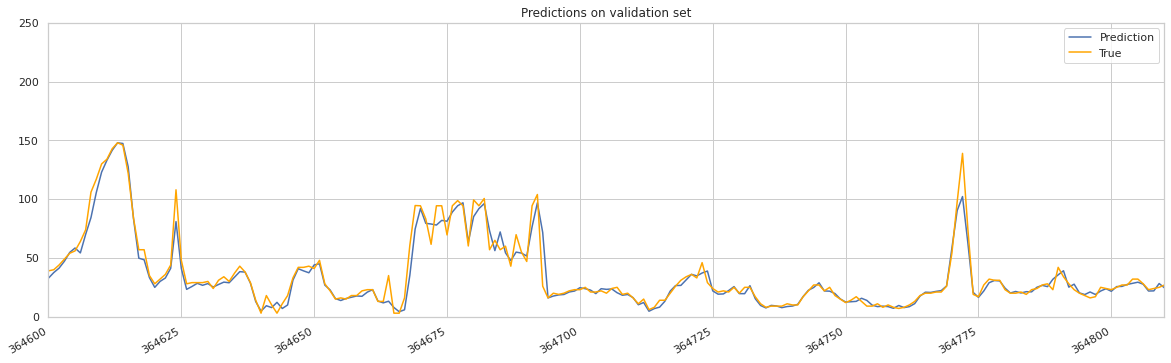

In [38]:
# Create fig size for plotting
fig, ax = plt.subplots(figsize=(20, 6))
# Plot the prediction
ax.plot(test["PM2.5"].index, predictions_lgb, color='b', label='Prediction')
# Plot the true values 
ax.plot(test["PM2.5"].index, test["PM2.5"], color='orange', label='True')

# Set title
ax.set_title("PM2.5", fontweight="bold", size=16)
# Set legend
ax.legend(loc="upper right")


## Rotate date labels automatically
ax.axis([364600, 364810, 0, 250])
fig.autofmt_xdate()
plt.title('Predictions on validation set')
plt.show()